
<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
<img border="0" src="http://www.auchylesmines.fr/wp-content/uploads/2015/03/Logo-securite-routiere-651x263.jpg" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>France accident challenge</h1></center>
<br/>
<center>Nayel Bettache (ENSAE), Axel Marchand (ENSAE), Solène Cochennec (HEC-ENSAE), Rodrigue Rillardon (ENSAE)</center>

Predicting accidents using Open Data Gouv Data: [Open Data Gouv](https://www.data.gouv.fr/fr/)

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

# Introduction

The objective of this challenge is to work with 'massive' and 'raw' data. We have a really high number of datasets, with most of the data either useless or at first not explained or use. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

We have at our disposal about 14 years of data about the road accidents in France from 2004 to 2018. We will only use 3 years to avoid using a dataset too huge. 

There are twelve datasets in this challenge, describing the years 2018, 2017, 2016. Each year has 4 differents datasets

* `caracteristiques_{YEAR}.csv` - basic data about the accidents.
* `lieux_{YEAR}.csv` - data about the location of the accidents.
* `usagers_{YEAR}.csv` - data about the people involved in the accidents.
* `vehicules_{YEAR}.csv` - data about the vehicles involved.


# Aim

The predictive aim of this challenge is to use the different datasets to predict the number of accidents for each location in a day. It is advised that you use all datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `caracteristiques_{YEAR}.csv` dataset is also allowed.

In [1]:
!python download_data.py

# Data


### Get the data 

In [1]:
import pandas as pd
import os
from data_cleaning import preparation_data 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
path = "/Users/solene/Desktop/France_accidents/data/" ## Path Solène 

## Concatenation des bases des différents années si concat=True 
df_caracteristiques, df_lieux, df_usagers, df_vehicules = preparation_data(path,concat=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Inside Preparation_data : 
- Si option concat (préférable) : 4 tables regroupant les années 2016, 2017 et 2019 chacune 
- Suppression des doublon dans la base caracteristiques
- Transformation des variablles an, mois et jour 
- Création des variables Date, heure et jour_semaine 


## Caracteristiques



$\textbf{List of features}:\\ $   
- Num_Acc : Accident number 
- An : année 
- Mois : Mois
- Jour : Jour 
- hrmn : heure et minutes
- lum : qualité de l'éclairage 
- agg : localisation ( 1: hors agglomération, 2: agglomération) 
- int : intersection 
- atm : conditions atmosphériques
- col : type de collision 
- com : commune (numéro donné par l'INSEE)  
- adr : adresse 
- gps : M (Métropoles), A (Antilles), G (Guyane), R (Réunion), Y (Mayotte)
- lat : latitude 
- long : longitude 
- dep : départmenet (code INSEE)

Beaucoup de duplicate, suppprimés dans preparation_data

In [8]:
df_caracteristiques.head(15)

Num_Acc    an mois jour  hrmn  lum  agg  int  atm  col  com  \
0   201800000001  2018   01   24  1505    1    1    4  1.0  1.0    5   
1   201800000002  2018   02   12  1015    1    2    7  7.0  7.0   11   
2   201800000003  2018   03   04  1135    1    2    3  1.0  7.0  477   
3   201800000004  2018   05   05  1735    1    2    1  7.0  3.0   52   
4   201800000005  2018   06   26  1605    1    2    1  1.0  3.0  477   
5   201800000006  2018   09   23  0630    2    2    1  2.0  6.0   52   
6   201800000007  2018   09   26  0040    5    2    1  1.0  6.0  133   
7   201800000008  2018   11   30  1715    5    2    1  1.0  6.0   11   
8   201800000009  2018   02   18  1557    1    1    1  1.0  6.0  550   
9   201800000010  2018   03   19  1530    1    2    2  1.0  1.0   51   
10  201800000011  2018   05   28  1830    1    2    6  1.0  3.0   51   
11  201800000012  2018   05   31  0430    5    1    6  5.0  6.0  250   
12  201800000013  2018   06   15  0845    1    1    1  1.0  3.0  257   
13  201800000014  2018   07   19  1022    1    2    1  1.0  6.0   51   
14  201800000015  2018   10   31  1945    3    1    1  1.0  6.0  303   

                         adr gps       lat     long  dep                Date  \
0     route des Ansereuilles   M  50.55737  2.94992  590 2018-01-24 15:05:00   
1   Place du général de Gaul   M  50.52936  2.93151  590 2018-02-12 10:15:00   
2             Rue  nationale   M  50.51243  2.91714  590 2018-03-04 11:35:00   
3        30 rue Jules Guesde   M  50.51974  2.89123  590 2018-05-05 17:35:00   
4         72 rue Victor Hugo   M  50.51607  2.90605  590 2018-06-26 16:05:00   
5                        D39   M  50.52132  2.88837  590 2018-09-23 06:30:00   
6         4 route de camphin   M  50.52211  2.96652  590 2018-09-26 00:40:00   
7          rue saint exupéry   M  50.53146  2.93875  590 2018-11-30 17:15:00   
8           rue de l'égalité   M  50.53707  2.84896  590 2018-02-18 15:57:00   
9    face au 59 rue de Lille   M  50.53639  2.81517  590 2018-03-19 15:30:00   
10         76 route de Lille   M  50.54194  2.81987  590 2018-05-28 18:30:00   
11                RN41-D 145   M  50.58465  2.90868  590 2018-05-31 04:30:00   
12                rue delval   M  50.61613  2.83783  590 2018-06-15 08:45:00   
13         26 rue d'estaires   M  50.53196  2.80251  590 2018-07-19 10:22:00   
14            rue chobourdin   M  50.57886  2.85234  590 2018-10-31 19:45:00   

    jour_semaine  heure  
0              2     15  
1              0     10  
2              6     11  
3              5     17  
4              1     16  
5              6      6  
6              2      0  
7              4     17  
8              6     15  
9              0     15  
10             0     18  
11             3      4  
12             4      8  
13             3     10  
14             2     19

In [9]:
df_caracteristiques.shape

(118484, 19)

In [10]:
df_caracteristiques.heure

0         15
1         10
2         11
3         17
4         16
          ..
118479    10
118480     6
118481    17
118482    14
118483    19
Name: heure, Length: 118484, dtype: int64

In [11]:
df_caracteristiques.dtypes

Num_Acc                  int64
an                      object
mois                    object
jour                    object
hrmn                    object
lum                      int64
agg                      int64
int                      int64
atm                    float64
col                    float64
com                      int64
adr                     object
gps                     object
lat                    float64
long                   float64
dep                      int64
Date            datetime64[ns]
jour_semaine             int64
heure                    int64
dtype: object

In [12]:
df_caracteristiques.isna().sum()

Num_Acc            0
an                 0
mois               0
jour               0
hrmn               0
lum                0
agg                0
int                0
atm               18
col                8
com                0
adr             1377
gps             4658
lat             9554
long            9554
dep                0
Date               0
jour_semaine       0
heure              0
dtype: int64

In [13]:
df_caracteristiques.nunique()

Num_Acc         118484
an                   2
mois                12
jour                31
hrmn              1419
lum                  5
agg                  2
int                 10
atm                  9
col                  7
com                853
adr              76499
gps                  5
lat              83821
long             89925
dep                101
Date             85690
jour_semaine         7
heure               24
dtype: int64

### Accidents en fonction des données temporelles

Somme des accidents en fonction du mois 

In [14]:
df_caracteristiques.mois.value_counts().sort_index()

01     8939
02     7546
03     9252
04     9945
05    10321
06    11514
07    10574
08     8789
09    10784
10    11222
11    10066
12     9532
Name: mois, dtype: int64

Somme des accidents en fonction du jour de la semaine (0:lundi ...) 

In [15]:
df_caracteristiques.jour_semaine.value_counts().sort_index()

0    15966
1    17254
2    16952
3    17522
4    19856
5    16641
6    14293
Name: jour_semaine, dtype: int64

Somme des accidents en fonction de l'heure

In [16]:
df_caracteristiques.heure.value_counts().sort_index()

0      2096
1      1750
2      1368
3      1245
4      1235
5      1803
6      2534
7      5220
8      6978
9      6018
10     5407
11     6016
12     6292
13     5843
14     6444
15     7219
16     8498
17    10297
18     9833
19     7660
20     5322
21     3828
22     3010
23     2568
Name: heure, dtype: int64

In [17]:
table = df_caracteristiques.pivot_table('Num_Acc', 'heure', 'jour_semaine', aggfunc="count")
table

jour_semaine     0     1     2     3     4     5     6
heure                                                 
0              204   194   210   240   301   473   474
1              156   139   160   180   231   417   467
2              110    86   102   133   197   331   409
3               93    98    92   134   153   315   360
4               95    91   109   112   178   305   345
5              186   154   165   185   206   424   483
6              326   315   307   333   374   371   508
7              900   928   902   882   844   331   433
8             1146  1345  1167  1319  1247   395   359
9              953  1131   924   993   973   612   432
10             740   837   799   861   828   785   557
11             802   872   890   834   930   975   713
12             830   911  1033   931  1024   884   679
13             810   881   887   843   970   824   628
14             858   933   979   928  1104   933   709
15             939   979  1064  1013  1262  1135   827
16            1201  1294  1200  1176  1546  1149   932
17            1496  1615  1548  1633  1791  1133  1081
18            1448  1457  1497  1556  1609  1212  1054
19             988  1124  1048  1137  1273  1128   962
20             652   688   694   767  1001   848   672
21             424   491   503   578   724   614   494
22             330   388   362   407   615   511   397
23             279   303   310   347   475   536   318

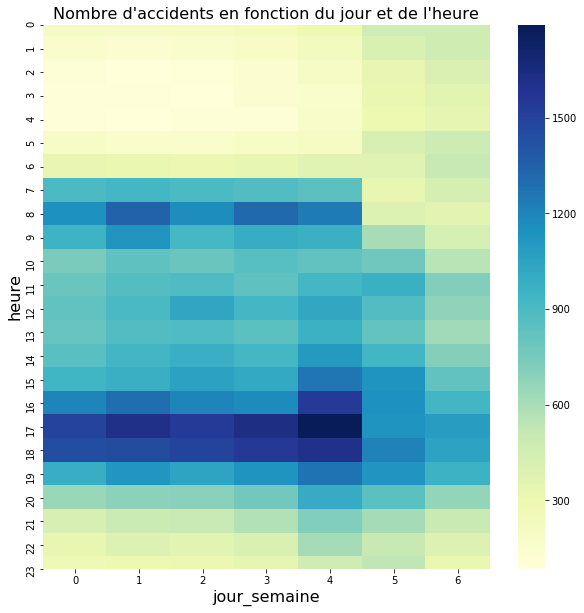

In [18]:
plt.figure(figsize=(10, 10))
plt.title('Nombre d\'accidents en fonction du jour et de l\'heure', fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)

heatmap = sns.heatmap(table,cmap="YlGnBu")

### Représentation des accidents en France en 2018

In [19]:
import folium
from folium.plugins import HeatMap

In [20]:
df_map = df_caracteristiques.dropna(subset=['lat','long'])
df_map = df_map[df_map.an=='2018']
df_map['count'] = 1

In [21]:
df_map.shape

(55960, 20)

In [22]:
def generateBaseMap(default_location=[48.85, 2.34], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [23]:
base_map = generateBaseMap()
HeatMap(data=df_map[['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

### Représentation des accidents en 2018 en fonction de l'heure de la journée 

In [24]:
from folium.plugins import HeatMapWithTime

In [25]:
df_map_list = []

for heure in df_map.heure.sort_values().unique():
    df_map_list.append(df_map.loc[df_map.heure == heure, ['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist()) 
    
df_heure_list = df_map.heure.sort_values().unique().tolist()


In [26]:
base_map = generateBaseMap(default_zoom_start=11)

HeatMapWithTime(data=df_map_list, index = df_heure_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

### Représentation des accidents en 2018 en fonction du jour de la semaine 

In [27]:
df_map_jour_list = []

for jour in df_map.jour_semaine.sort_values().unique():
    df_map_jour_list.append(df_map.loc[df_map.jour_semaine == jour, ['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist()) 
    
df_jour_list = df_map.jour_semaine.sort_values().unique().tolist()


In [28]:
base_map = generateBaseMap(default_zoom_start=11)

HeatMapWithTime(data=df_map_jour_list, index = df_jour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Lieux



$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident 
- catr: Catégorie de route 
- voie : numéro de route 
- V1 : indice numérique du numéro de route (2 bis etc.) 
- V2 : lettre indice alphanumérique de la route 
- circ: régime de circulation (sens unique...) 
- nbv: nombre total de voies de circulation  
- vosp : signal l'existence de voie réservée (pidte cyclable...) 
- prof : pente de la route (1: plat..) 
- pr : numéro du PR de rattrachement (borne amont) 
- pr1 : distance en mètres au PR 
- plan : tracé en plan (courbe ou ligne droite...) 
- lartpc : largeur du terre plein central si existant 
- larrout : largueur de la chaussée affectée à la circulation des véhicules 
- surf : état de la surface (normale, mouillée...) 
- infra : infrastructure (pont, tunnel) 
- situ : situation de l'accident (chaussée, trottoir...) 
- env1 : indicatrice proximité d'une école 

In [9]:
df_lieux.head(5)

Num_Acc  catr voie  v1   v2  circ  nbv  pr  pr1  vosp  prof  plan  \
0  201800000001     3   41 NaN    C   2.0  2.0 NaN  NaN   0.0   1.0   3.0   
1  201800000002     4   41 NaN    D   2.0  2.0 NaN  NaN   0.0   1.0   2.0   
2  201800000003     3   39 NaN    D   2.0  2.0 NaN  NaN   0.0   1.0   1.0   
3  201800000004     3   39 NaN  NaN   2.0  2.0 NaN  NaN   0.0   1.0   1.0   
4  201800000005     4  NaN NaN  NaN   1.0  1.0 NaN  NaN   0.0   1.0   1.0   

   lartpc  larrout  surf  infra  situ  env1  
0     NaN      NaN   1.0    0.0   1.0   0.0  
1     NaN      NaN   1.0    0.0   1.0   0.0  
2     NaN      NaN   1.0    0.0   1.0   0.0  
3     NaN      NaN   1.0    0.0   1.0   0.0  
4     NaN      NaN   1.0    0.0   1.0   0.0

In [10]:
df_lieux.shape 

(177916, 18)

In [11]:
df_lieux.nunique()

Num_Acc    177916
catr            8
voie         1861
v1              2
v2             52
circ            5
nbv            14
pr            569
pr1          1492
vosp            4
prof            5
plan            5
lartpc        263
larrout       418
surf           10
infra           8
situ            6
env1            3
dtype: int64

## Usagers



$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident, NON unique, puisque même numéro pour chaque usager de l'accident 
- place: place dans le véhicule au moment de l'accident (1: conducteur) 
- catu : catégorie d'usager (conducteur, passager, piéton ...) 
- grav : gravité de l'accident (1: indemne, 2: Tué, 3: Blessé hospitalisé et 4: Blessé léger) 
- sexe : 1 (Masculin), 2 (Féminin) 
- trajet : motif du déplacement (domicile-travail etc )  
- sécu : équipement de sécurité et unitilisation de l'équipement (11 = 1: ceinture + 1: Oui )
- locp: localisation du piéton 
- actp : action du piéton 
- étatp : piéton seul ou non 
- an_nais : année de naissance de l'usager
- num_veh : identifiant du véhicule 

In [12]:
df_usagers.head(15)

Num_Acc  place  catu  grav  sexe  trajet  secu  locp  actp  etatp  \
0   201800000001    1.0     1     3     1     0.0  11.0   0.0   0.0    0.0   
1   201800000001    1.0     1     1     1     5.0  11.0   0.0   0.0    0.0   
2   201800000002    1.0     1     1     1     0.0  11.0   0.0   0.0    0.0   
3   201800000002    NaN     3     4     1     0.0   2.0   2.0   3.0    1.0   
4   201800000003    1.0     1     3     1     5.0  21.0   0.0   0.0    0.0   
5   201800000003    1.0     1     1     1     0.0   3.0   0.0   0.0    0.0   
6   201800000004    1.0     1     3     1     5.0   2.0   0.0   0.0    0.0   
7   201800000004    1.0     1     1     1     5.0  11.0   0.0   0.0    0.0   
8   201800000005    1.0     1     4     1     5.0  21.0   0.0   0.0    0.0   
9   201800000005    1.0     1     1     1     5.0  11.0   0.0   0.0    0.0   
10  201800000006    1.0     1     1     1     0.0   3.0   0.0   0.0    0.0   
11  201800000006    2.0     2     1     1     0.0   3.0   0.0   0.0    0.0   
12  201800000006    9.0     2     4     1     0.0   3.0   0.0   0.0    0.0   
13  201800000006    NaN     3     3     1     0.0   2.0   0.0   0.0    0.0   
14  201800000007    1.0     1     3     1     9.0  11.0   0.0   0.0    0.0   

    an_nais num_veh  
0    1928.0     B01  
1    1960.0     A01  
2    1947.0     A01  
3    1959.0     A01  
4    1987.0     A01  
5    1977.0     C01  
6    2013.0     B01  
7    1982.0     A01  
8    2001.0     A01  
9    1946.0     B01  
10   1984.0     A01  
11   1992.0     A01  
12   1995.0     A01  
13   1959.0     A01  
14   1996.0     A01

In [13]:
df_usagers.shape

(399612, 12)

In [14]:
df_usagers.nunique()

Num_Acc    177916
place           9
catu            4
grav            4
sexe            2
trajet          7
secu           18
locp            9
actp            8
etatp           4
an_nais       106
num_veh        86
dtype: int64

## Vehicles


$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident, NON unique, puisque même numéro pour chaque véhicule de l'accident 
- senc : sens de circulation 
- catv : catégorie du véhicule 
- occutc : nombre d'occupants dans le transport en commun 
- obs : obstacle fixe heurté (type) 
- obsm : obstacle mobile heurté 
- choc : point de choc initiale (1: avant, 2: avant droit...) 
- manv : manoeuvre principale avant l'accident (1: sans chgt de direction, 4: en marche arrière...) 
- num_veh : identifiant du véhicule (repris dans la base usager)

In [17]:
df_vehicules.head(15)

Num_Acc  senc  catv  occutc   obs  obsm  choc  manv num_veh
0   201800000001   0.0     7       0   0.0   2.0   3.0   1.0     B01
1   201800000001   0.0     7       0   0.0   2.0   2.0  15.0     A01
2   201800000002   0.0     7       0   0.0   1.0   0.0   1.0     A01
3   201800000003   0.0    33       0   1.0   2.0   1.0   1.0     A01
4   201800000003   0.0     7       0   0.0   2.0   8.0  15.0     B01
5   201800000003   0.0     7       0   0.0   0.0   7.0  24.0     C01
6   201800000004   0.0     1       0   0.0   2.0   8.0   0.0     B01
7   201800000004   0.0     7       0   0.0   9.0   2.0  21.0     A01
8   201800000005   0.0     2       0   0.0   2.0   2.0  17.0     A01
9   201800000005   0.0     7       0   0.0   2.0   3.0  20.0     B01
10  201800000006   0.0     7       0   6.0   1.0   2.0   1.0     A01
11  201800000007   0.0     7       0   8.0   0.0   8.0   0.0     A01
12  201800000008   0.0     7       0   0.0   1.0   2.0   1.0     A01
13  201800000009   1.0    33       0  16.0   0.0   3.0   1.0     A01
14  201800000010   0.0    33       0   0.0   2.0   1.0  17.0     A01

In [20]:
df_vehicules.nunique()

Num_Acc    177916
senc            3
catv           24
occutc         92
obs            17
obsm            7
choc           10
manv           25
num_veh        87
dtype: int64

In [22]:
df_vehicules.isna().sum()

Num_Acc      0
senc       272
catv         0
occutc       0
obs        282
obsm       227
choc       179
manv       169
num_veh      0
dtype: int64


## Training and test

# Merge the databases 

In [1]:
df_merge = pd.merge(df_caracteristiques, df_lieux, left_on="Num_Acc", right_on="Num_Acc")  
df_merge

NameError: name 'pd' is not defined

# Score metric

# Data exploration

## Caracteristiques

## Lieux

## Usagers

TEST